## Data exploration

This project analyzes the TMDB 5000 Movies dataset to explore the relationships between budget, revenue, genres, and other features.
In this notebook, we perform initial data exploration, assess missing values, and identify potential quality issues before cleaning.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import glob
from src.utils import split_csv

We begin by loading the two datasets:

movies → contains metadata (title, budget, revenue, genres, release date, etc.)

credits → contains cast and crew information

We merge them on the movie ID to create a single dataset.

In [3]:
movies = pd.read_csv("../data/raw/tmdb_5000_movies.csv")
credits = pd.read_csv("../data/raw/tmdb_5000_credits.csv")

print(movies.columns)
print(credits.columns)

# Merging the 2 datasets
credits.rename(columns={'movie_id': 'id'}, inplace=True)
df = movies.merge(credits, on='id')

Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')
Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')


In [4]:
# Checking if 'title' is the same in both initial dataframes:

print(f'Columns: {df.columns}')
print((df['title_x'] == df['title_y']).all())

Columns: Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title_x', 'vote_average',
       'vote_count', 'title_y', 'cast', 'crew'],
      dtype='object')
True


In [5]:
# They are, so we remove 'title_y'

df = df.drop(columns=['title_y']).rename(columns={'title_x': 'title'})

### Inspecting the data

We look at basic info to understand column types, distributions, and potential anomalies.

In [6]:
print(f'Columns: {df.columns}')
print(df.describe())
print(df.info())
print(df.head())

Columns: Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count', 'cast', 'crew'],
      dtype='object')
             budget             id   popularity       revenue      runtime  \
count  4.803000e+03    4803.000000  4803.000000  4.803000e+03  4801.000000   
mean   2.904504e+07   57165.484281    21.492301  8.226064e+07   106.875859   
std    4.072239e+07   88694.614033    31.816650  1.628571e+08    22.611935   
min    0.000000e+00       5.000000     0.000000  0.000000e+00     0.000000   
25%    7.900000e+05    9014.500000     4.668070  0.000000e+00    94.000000   
50%    1.500000e+07   14629.000000    12.921594  1.917000e+07   103.000000   
75%    4.000000e+07   58610.500000    28.313505  9.291719e+07   118.000000   
max    3.800

### Looking at missing values

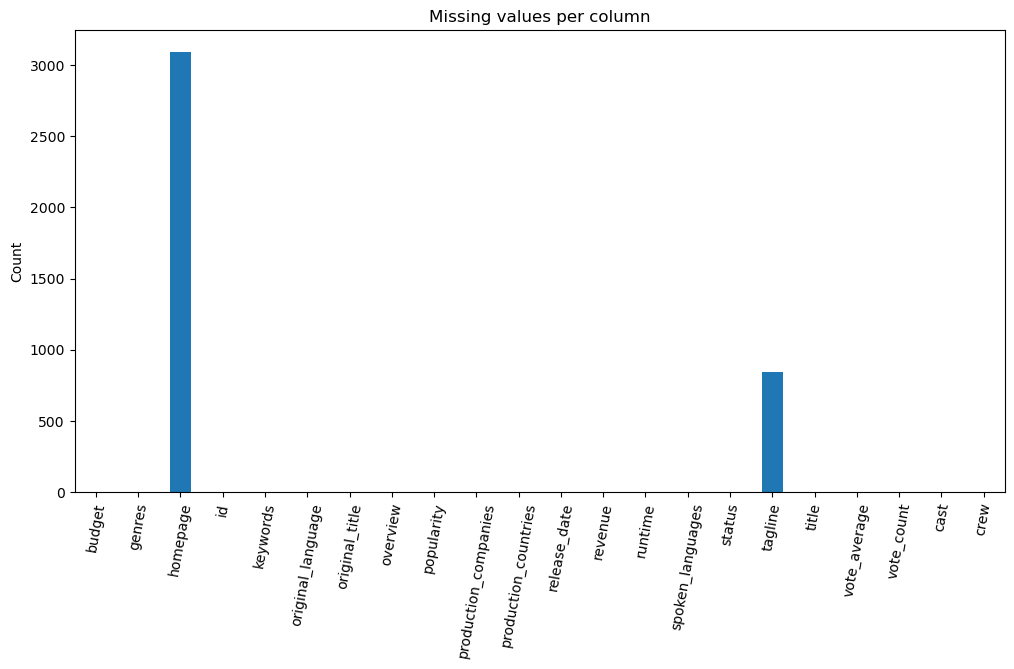

In [8]:
plt.figure(figsize=(12,6))
df.isnull().sum().plot(kind="bar")
plt.title("Missing values per column")
plt.ylabel("Count")
plt.xticks(rotation=80)
plt.show()

We observe there are missing values in some columns, mostly in "homepage" and 'tagline' (also a few missing values in 'release_date', 'overview'and 'runtime', as seen in df info).

### Data quality checks

Investigated a possible data quality issues: movies with zero budget, zero revenue, movies with budget=0 but non-zero revenue (e.g., Alvin and the Chipmunks)

We concluded that budget=0 or revenue=0 means missing, not literal zero:

In [9]:
print(f'Number of movies with no budget: {(df["budget"] == 0).sum()}\nNumber of movies with no revenue: {(df["revenue"] == 0).sum()}')
# high number of movies with no budget or no revenue

Number of movies with no budget: 1037
Number of movies with no revenue: 1427


In [50]:
print(df[(df["budget"]==0) & (df["revenue"]!=0)].title)

321                               The Campaign
359     Alvin and the Chipmunks: The Road Chip
409                              All That Jazz
475                                   The Edge
489                                     Oceans
                         ...                  
4605                                  Dogtooth
4630                                Compliance
4677                                     Three
4766                            The Last Waltz
4775                               Funny Ha Ha
Name: title, Length: 147, dtype: object


We find some movies that have no budget but still have revenue: they could be just interesting quirks, but checking 'Alvin and the Chipmunks: The Road Chip' on Wikipedia quickly gives the real budget of the movie: $90 million. There must be missing data about some of the movies' budgets that was replaced with zeros. For further analysis, we will treat 0 in revenue/budget as missing data. It is one data quality issue we stumble upon at the exploration stage already.

In [56]:
# Checking the time period the data comes from

df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
print(df['release_date'].min(), df['release_date'].max())

1916-09-04 00:00:00 2017-02-03 00:00:00


In [7]:
print(df.head())

      budget                                             genres  \
0  237000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
1  300000000  [{"id": 12, "name": "Adventure"}, {"id": 14, "...   
2  245000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   
3  250000000  [{"id": 28, "name": "Action"}, {"id": 80, "nam...   
4  260000000  [{"id": 28, "name": "Action"}, {"id": 12, "nam...   

                                       homepage      id  \
0                   http://www.avatarmovie.com/   19995   
1  http://disney.go.com/disneypictures/pirates/     285   
2   http://www.sonypictures.com/movies/spectre/  206647   
3            http://www.thedarkknightrises.com/   49026   
4          http://movies.disney.com/john-carter   49529   

                                            keywords original_language  \
0  [{"id": 1463, "name": "culture clash"}, {"id":...                en   
1  [{"id": 270, "name": "ocean"}, {"id": 726, "na...                en   
2  [{"id": 470, "nam

### Saving the files:

In [8]:
df.to_csv("../data/processed/movies_merged.csv", index=False)
split_csv("../data/processed/movies_merged.csv", "../data/processed/merged", "merged_split", chunk_size=1000)

Saved ../data/processed/merged\merged_split_part1.csv (1000 rows)
Saved ../data/processed/merged\merged_split_part2.csv (1000 rows)
Saved ../data/processed/merged\merged_split_part3.csv (1000 rows)
Saved ../data/processed/merged\merged_split_part4.csv (1000 rows)
Saved ../data/processed/merged\merged_split_part5.csv (803 rows)
